## Here, linear PCA is used to reduce the number of parameters from 28 to a smaller number. As threshold for PCA value of 0.95 is used.

In [2]:
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd
import random
import copy

In [43]:
f=h5py.File("norm_params.hdf5","r")
P=f["Parameters"]
T=f["Time"]

Because the parameters are normalized (mean-subtracrted), the covariance matrix can be obtained by simply multiplying the parameter matrix by its transpose.

In [10]:
Cov_P=np.matmul(np.transpose(P),P)/(len(P)-1)

In [11]:
L,V=np.linalg.eig(Cov_P)
L=L/np.sum(L)

In [25]:
Eigs=[(i,val) for i,val in enumerate(L)]
Eigs=sorted(Eigs,key=lambda tup:tup[1],reverse=True)

We enumarete the eigenvalues and find indices of the biggest ones that sum to 0.95. Then, we use eigenvectors with these indices to generate new parameters.

In [28]:
Inds=[]

sm=0
k=0
while sm<0.95:
    sm+=Eigs[k][1]
    Inds.append(Eigs[k][0])
    k+=1
print('Dimensionality is reduced to {} parameters'.format(k))

Dimensionality is reduced to 11 parameters


In [31]:
N=len(T)
New_P=np.zeros((N,k))

for i in range(N):
    k=0
    for j in Inds:
        New_P[i,k]=np.dot(V[:,j],P[i,:])
        k+=1

### 5 biggest principle components

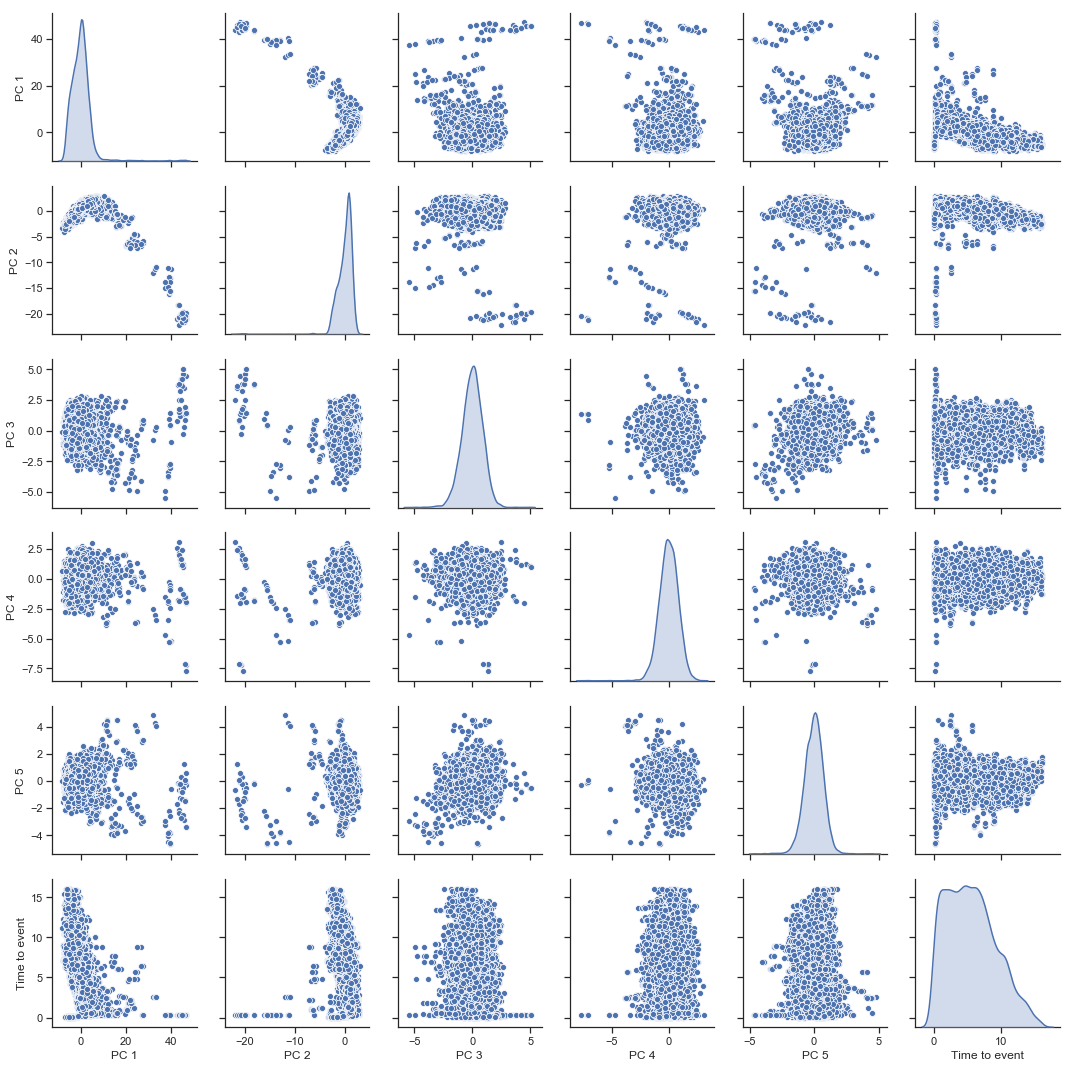

In [33]:
d = {"PC 1":New_P[:,0],"PC 2":New_P[:,1],"PC 3":New_P[:,2],"PC 4":New_P[:,3],"PC 5":New_P[:,4],"Time to event":T}
df = pd.DataFrame(data=d)
g=sns.pairplot(df,diag_kind="kde")

In [34]:
fw=h5py.File("PCA_params.hdf5","w")
fw.create_dataset('Parameters',data=New_P)
fw.create_dataset("Time",data=T)
fw.create_dataset("Wavelet",data=f['Wavelet'])
fw.create_dataset("Artificial_wavelet",data=f['Artificial_wavelet'])
fw.close()

f.close()

Let's look at the scatter plot showing two principle components.

Text(0, 0.5, 'Parameter 2')

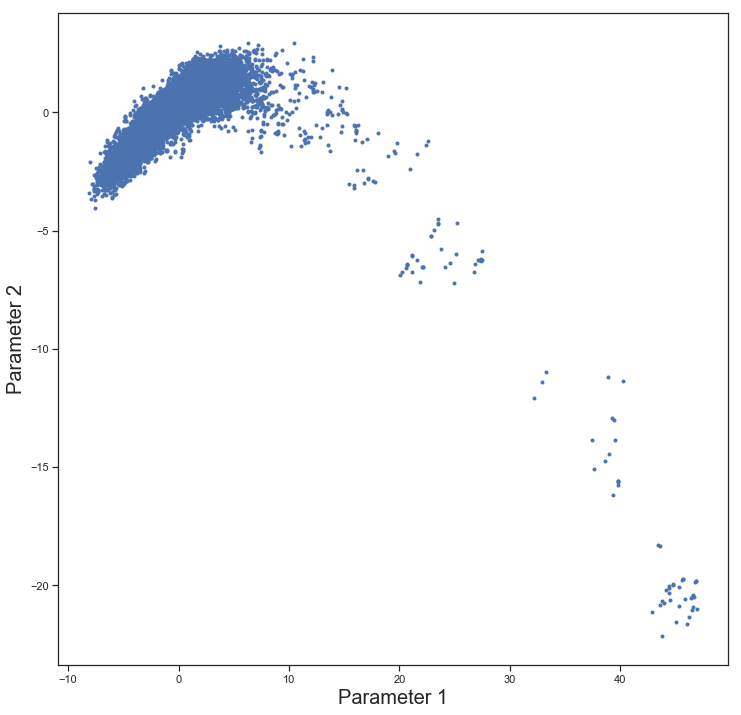

In [39]:
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111)
ax.plot(New_P[:,0],New_P[:,1],'.')
ax.set_xlabel("Parameter 1",fontsize=20)
ax.set_ylabel("Parameter 2",fontsize=20)

They seem to explain a lot. We can use this plot to see what's the best time limit for the low-time-to-event class.

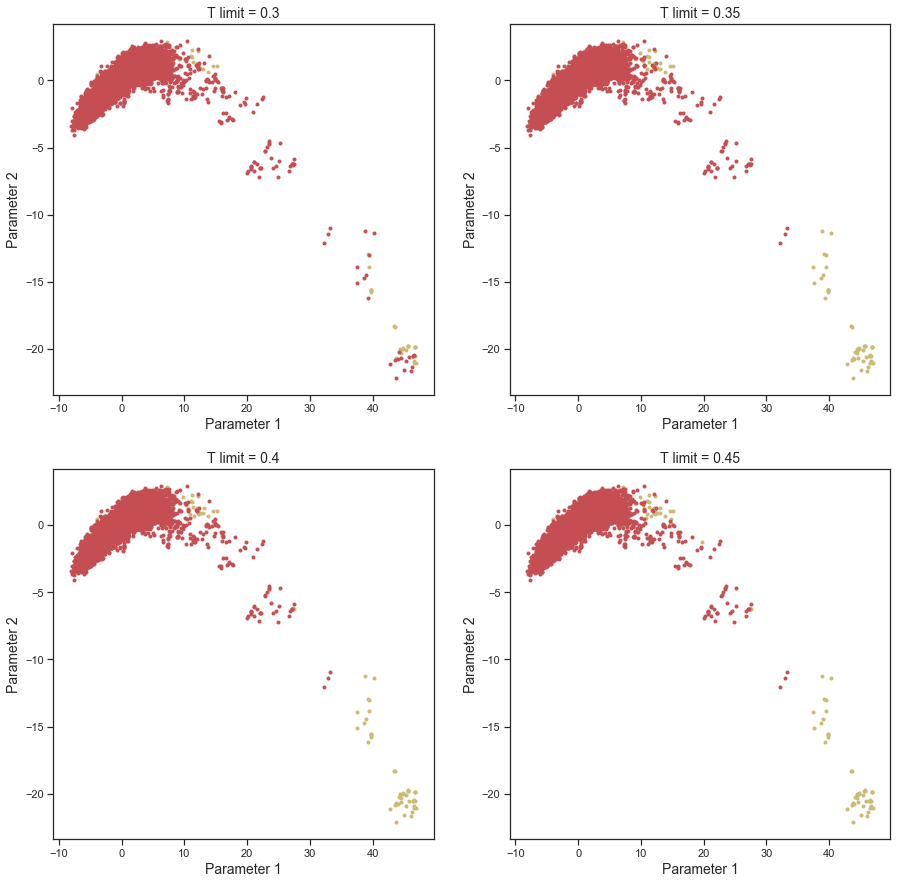

In [50]:
time_limits=[0.3,0.35,0.4,0.45]

fig,ax=plt.subplots(2,2,figsize=(15,15))

ax=[ax[0,0],ax[0,1],ax[1,0],ax[1,1]]


j=0
for t_lim in time_limits:
    P0_below=[]
    P0_above=[]
    P1_below=[]
    P1_above=[]
    
    for i in range(N):
        if T[i]<t_lim:
            P0_below.append(New_P[i,0])
            P1_below.append(New_P[i,1])
        else:
            P0_above.append(New_P[i,0])
            P1_above.append(New_P[i,1])
    
    ax[j].plot(P0_below,P1_below,'y.')
    ax[j].plot(P0_above,P1_above,'r.')
    ax[j].set_title('T limit = {}'.format(t_lim),fontsize=14)
    ax[j].set_xlabel("Parameter 1",fontsize=14)
    ax[j].set_ylabel("Parameter 2",fontsize=14)
    j+=1

The above shows that 0.35 is more or less the best limiting time. 0.3 does not include the bottom-right cluster, while 0.4 and higher starts to include more and more data from the top-left cluster. Let's also take a quick look at other clusters.

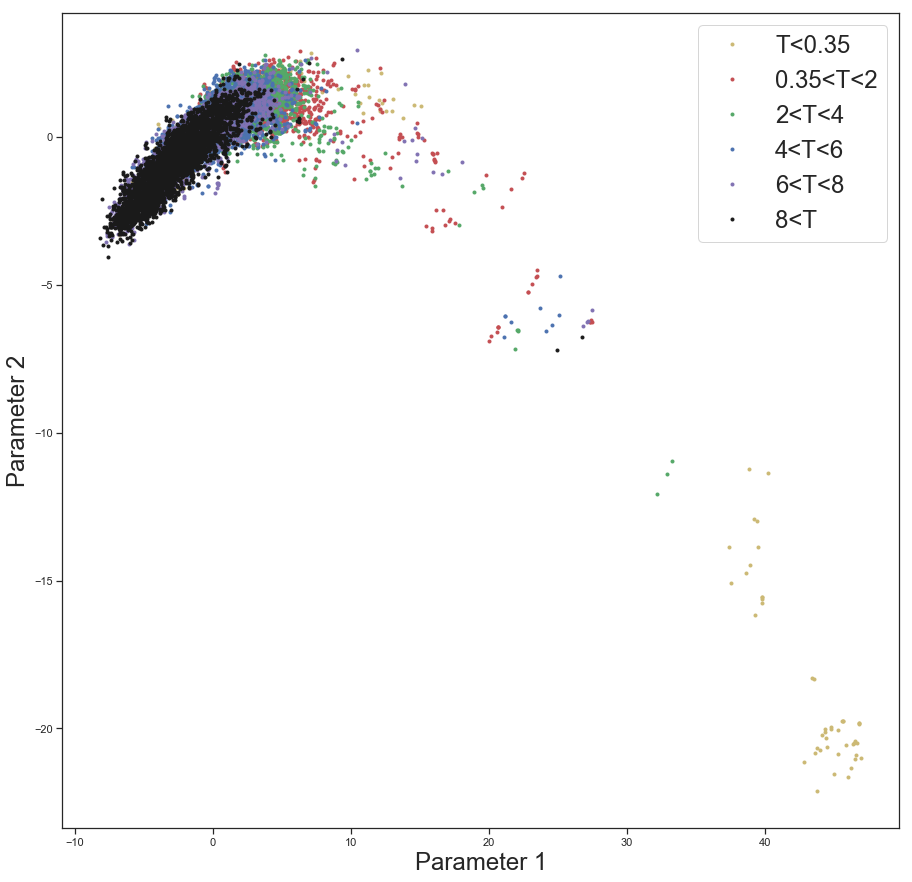

In [53]:
time_boundaries=[0.35,2,4,6,8]

fig,ax=plt.subplots(1,1,figsize=(15,15))

j=0

P0_0=[]
P0_2=[]
P0_4=[]
P0_6=[]
P0_8=[]
P0_more=[]
P1_0=[]
P1_2=[]
P1_4=[]
P1_6=[]
P1_8=[]
P1_more=[]
    
for i in range(N):
    if T[i]<time_boundaries[0]:
        P0_0.append(New_P[i,0])
        P1_0.append(New_P[i,1])
    elif T[i]<time_boundaries[1]:
        P0_2.append(New_P[i,0])
        P1_2.append(New_P[i,1])
    elif T[i]<time_boundaries[2]:
        P0_4.append(New_P[i,0])
        P1_4.append(New_P[i,1])
    elif T[i]<time_boundaries[3]:
        P0_6.append(New_P[i,0])
        P1_6.append(New_P[i,1])
    elif T[i]<time_boundaries[4]:
        P0_8.append(New_P[i,0])
        P1_8.append(New_P[i,1])
    else:
        P0_more.append(New_P[i,0])
        P1_more.append(New_P[i,1])
    
ax.plot(P0_0,P1_0,'y.',label='T<0.35')
ax.plot(P0_2,P1_2,'r.',label='0.35<T<2')
ax.plot(P0_4,P1_4,'g.',label='2<T<4')
ax.plot(P0_6,P1_6,'b.',label='4<T<6')
ax.plot(P0_8,P1_8,'m.',label='6<T<8')
ax.plot(P0_more,P1_more,'k.',label='8<T')
ax.set_xlabel("Parameter 1",fontsize=24)
ax.set_ylabel("Parameter 2",fontsize=24)
ax.legend(fontsize=24)

Text(0.5, 1.0, '8<T')

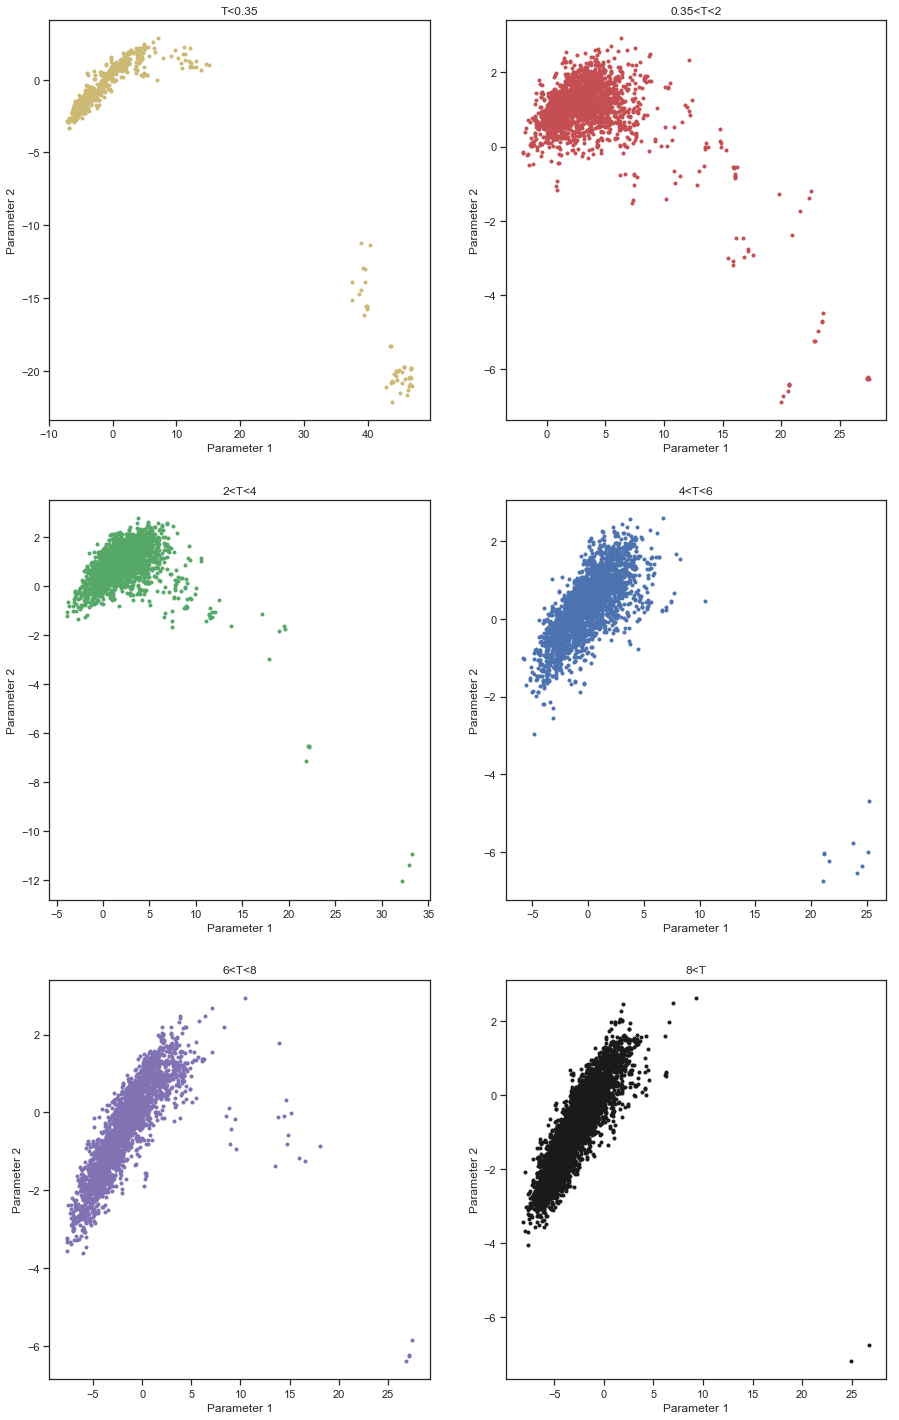

In [54]:
fig,ax=plt.subplots(3,2,figsize=(15,25))
ax[0,0].plot(P0_0,P1_0,'y.')
ax[0,0].set_xlabel("Parameter 1",fontsize=12)
ax[0,0].set_ylabel("Parameter 2",fontsize=12)
ax[0,0].set_title('T<0.35')

ax[0,1].plot(P0_2,P1_2,'r.')
ax[0,1].set_xlabel("Parameter 1",fontsize=12)
ax[0,1].set_ylabel("Parameter 2",fontsize=12)
ax[0,1].set_title('0.35<T<2')

ax[1,0].plot(P0_4,P1_4,'g.')
ax[1,0].set_xlabel("Parameter 1",fontsize=12)
ax[1,0].set_ylabel("Parameter 2",fontsize=12)
ax[1,0].set_title('2<T<4')

ax[1,1].plot(P0_6,P1_6,'b.')
ax[1,1].set_xlabel("Parameter 1",fontsize=12)
ax[1,1].set_ylabel("Parameter 2",fontsize=12)
ax[1,1].set_title('4<T<6')

ax[2,0].plot(P0_8,P1_8,'m.')
ax[2,0].set_xlabel("Parameter 1",fontsize=12)
ax[2,0].set_ylabel("Parameter 2",fontsize=12)
ax[2,0].set_title('6<T<8')

ax[2,1].plot(P0_more,P1_more,'k.')
ax[2,1].set_xlabel("Parameter 1",fontsize=12)
ax[2,1].set_ylabel("Parameter 2",fontsize=12)
ax[2,1].set_title('8<T')

This last graph shows quite well that most of the data points are clustered together and making any prediction will be challenging.